# **Task 5: Analysis of Extragalactic Objects' Spectra:**
This example meant to walk you through the basic analysis of 1-dimension spectra of extragalactic objects such as galaxies and active galactic nuclei. The example spectra has been wavelength and flux calibrated.  

Install the following require packages:


*   astroquery
*   astropy
*   extinction




In [ ]:
#!pip install astroml
!pip install astropy
!pip install astroquery
!pip install extinction
!pip install astroML
# Installing needed Python packages

First, let's call in the usual suspects (i.e. import normally used packages)


*   NumPy
*   SciPy
*   Matplotlib.Pyplot

And also the packages you just installed (for online participants).



In [148]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy import units as u
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM


from astroquery.sdss import SDSS
from scipy.optimize import curve_fit, least_squares, minimize
from scipy import signal
from scipy.stats import skewnorm
from astroML.datasets import fetch_sdss_spectrum
from urllib.error import HTTPError



#**Block 5.1:**
Now, we can assume that an emission feature of the spectra follow a certain well-known shape--Gaussian Distribution. Caveat: This assumption hold true for most cases (but not all cases).

gaussian_function.svg

Let's define a function for gaussian distribution, where f(x) is the flux density (in the unit of erg/s/cm^2/angstrom for instance) and "x" as wavelength.

In [5]:
def gaussian_profile(x,scale_height,centroid,sigma):
  flux_dens = scale_height*np.exp(-1.0*((x - centroid)**2.0)/(2.0*sigma**2.0))
  return flux_dens

Now, test that your function is working properly.

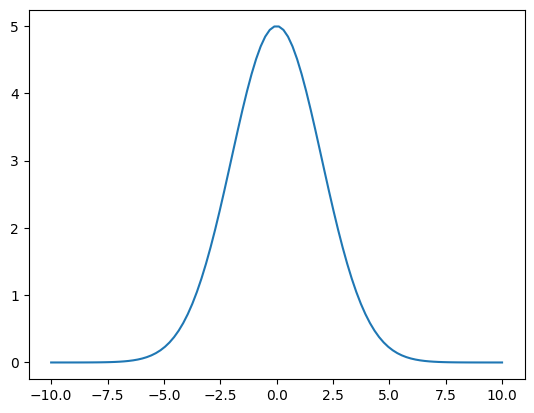

In [6]:
x_test = np.linspace(-10.0,10.0,100)
centroid_test = 0.0
sigma_test = 2.0
scale_height = 5.0
flux_dens_test = gaussian_profile(x_test,scale_height,centroid_test,sigma_test)

plt.plot(x_test, flux_dens_test)

#**Block 5.2:**
**Good, good, good!**

Now, we are (somewhat) ready to fit some emission lines.

*   Read in (download) the a spectrum of a suspected active galactic nucleus.
*   Use the text file provided (in data/ folder).
*   Select any source in that file.
*   Use astroquery to obtain its spectrum from the SDSS survey.


[ 1.3416500e-17 -7.5760397e-18  4.5312200e-17 ...  1.3258500e-16
  1.3259000e-16  1.3259499e-16] erg / (Angstrom s cm2)


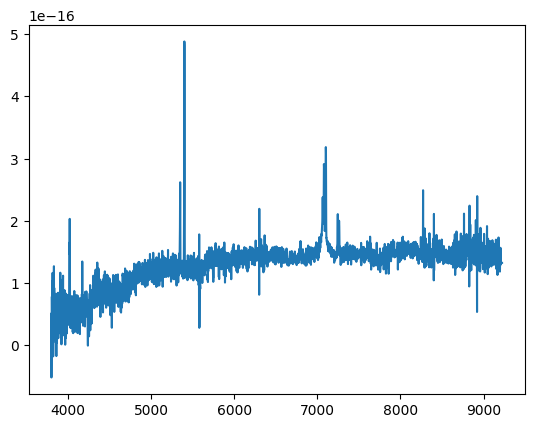

In [120]:
data_file_path = 'data/table_dr17_all_low_luminosity_AGN.csv'
objID, ra, dec, plate, fiberID, redshift_table, mjd_plate = np.loadtxt(data_file_path, usecols=(0,1,2,13,14,15,22), unpack=True, skiprows=1, delimiter=',')

def get_sdss_spec(plate,mjd,fiber): # in Place of 'Macro subtract_plot 13'
    try:
        spec = fetch_sdss_spectrum(plate, mjd, fiber)
    except HTTPError:
        print("%i, %i, %i not found" % (plate, mjd, fiber))
        spec = None
    return spec

index = 3
spec1 = get_sdss_spec(plate[index],mjd_plate[index],fiberID[index])

wvl_1      = spec1.wavelength()*u.AA
flux_1     = spec1.spectrum*1.0e-17 *u.Unit('erg s^-1 cm^-2 AA^-1')
flux_err_1 = spec1.error
snr_1      = 1.0/np.median(flux_err_1/flux_1)
z_listed_1 = spec1.z

plt.plot(wvl_1,flux_1)
print(flux_1)


Now, zoom in to see whether you can recognize any prominent emission feature, like HAlpha?


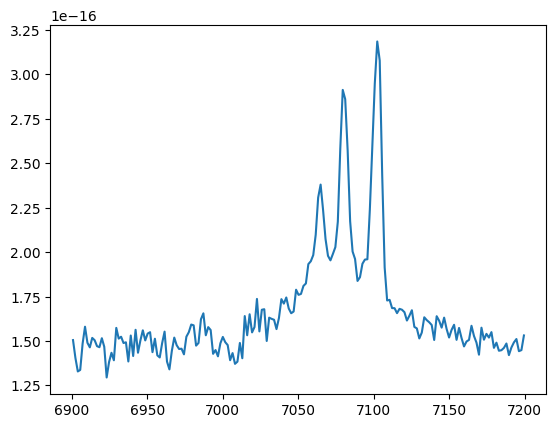

In [122]:
slice_1 = np.where((wvl_1/u.AA > 6900.0) & (wvl_1/u.AA < 7200.0))

plt.plot(wvl_1[slice_1],flux_1[slice_1])


#**Block 5.3:**
**Is single Gaussian fit gonna be enough?**

As you might have realized at this point, this is possibly a blended gaussian with multiple narrow lines and (maybe) a broad component. The spectral resolution of SDSS at R~1000 does not help either.
This features is typical for what we call Seyfert-I galaxies, which is an AGN with visible host galaxy.


*   Build on your gaussian function defined earlier.
*   Transform it into multiple-Gaussian model (3 narrow lines + 1 broad component)
*   Use the new model to fit the spectrum and obtain the best-fitted redshift.
*   Compared this to the redshift you obtain from SDSS catalog.
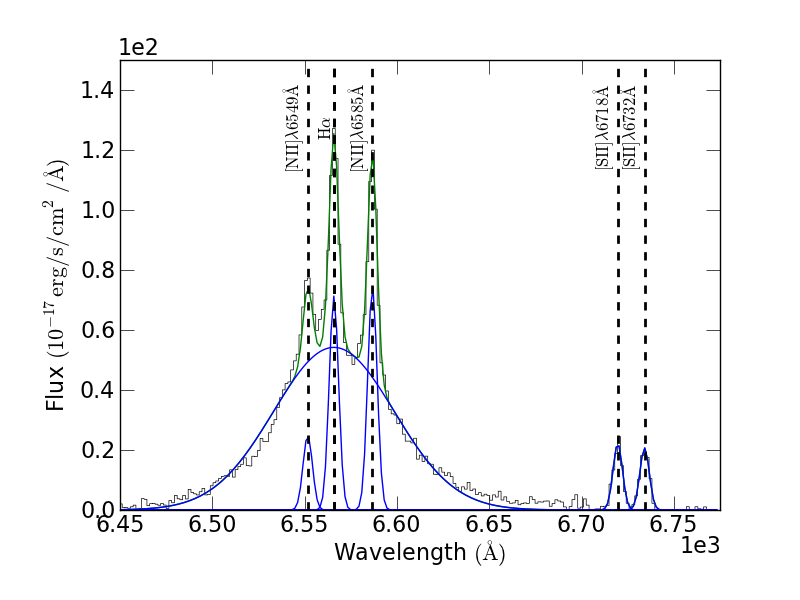.


[ 3.54128732e+00  5.25088432e+00  4.93029029e+00  5.23805413e+00
  4.44969182e-17  4.65568941e-17  1.41020561e-16  1.01446614e-16
  3.09021330e+01  2.77529262e+00  2.72953323e+00 -2.52563565e+00
  1.48339055e-16]
0.07828751047968607 0.0784862


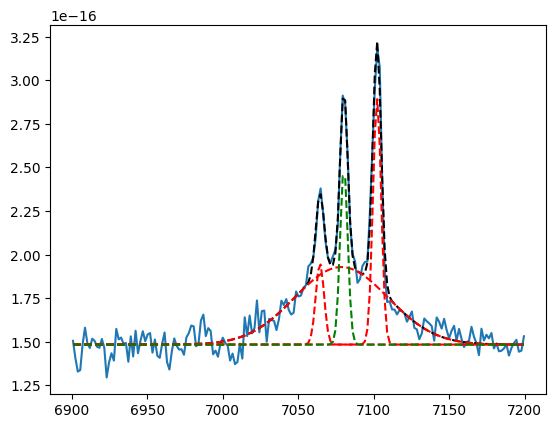

In [159]:
def gaussian_profile(x,scale_height,centroid,sigma):
  flux_dens = scale_height*np.exp(-1.0*((x - centroid)**2.0)/(2.0*sigma**2.0))
  return flux_dens

NIIa = 6549.86
NIIb = 6585.27
Halpha = 6564.614

peak_guess0 = 7075.0
peak_guess1 = peak_guess0/Halpha*NIIa
peak_guess2 = peak_guess0/Halpha*NIIb
peak_guess3 = peak_guess0


def multi_gaussian4(x,x0, x1, x2, x3, h0, h1, h2, h3, s0, s1, s2, s3, base):
  f0 = gaussian_profile(x,h0,(peak_guess0 + x0),s0)
  f1 = gaussian_profile(x,h1,(peak_guess1 + x1) ,s1)
  f2 = gaussian_profile(x,h2,(peak_guess2 + x2) ,s2)
  f3 = gaussian_profile(x,h3,(peak_guess3 + x3) ,s3)
  f_total = f0 + f1 + f2 + f3 + base
  return f_total

p_agn1, pv_agn1 = curve_fit(multi_gaussian4, wvl_1.value[slice_1], flux_1.value[slice_1])
print(p_agn1)

z_fitted = (peak_guess0 + p_agn1[0])/Halpha - 1.0
print(z_fitted, z_listed_1)
plt.plot(wvl_1[slice_1], flux_1[slice_1])
plt.plot(wvl_1[slice_1], multi_gaussian4(wvl_1.value[slice_1],p_agn1[0], p_agn1[1], p_agn1[2], p_agn1[3],
                                                      p_agn1[4], p_agn1[5], p_agn1[6], p_agn1[7], p_agn1[8],
                                                      p_agn1[9], p_agn1[10], p_agn1[11], p_agn1[12]), 'k--')
plt.plot(wvl_1[slice_1], gaussian_profile(wvl_1.value[slice_1],p_agn1[4],p_agn1[0]+peak_guess0, p_agn1[8])+p_agn1[12], 'r--')
plt.plot(wvl_1[slice_1], gaussian_profile(wvl_1.value[slice_1],p_agn1[5],p_agn1[1]+peak_guess1, p_agn1[9])+p_agn1[12], 'r--')
plt.plot(wvl_1[slice_1], gaussian_profile(wvl_1.value[slice_1],p_agn1[6],p_agn1[2]+peak_guess2, p_agn1[10])+p_agn1[12], 'r--')
plt.plot(wvl_1[slice_1], gaussian_profile(wvl_1.value[slice_1],p_agn1[7],p_agn1[3]+peak_guess3, p_agn1[11])+p_agn1[12], 'g--')


#**Block 5.4:**
**Beautify Your Plot of Multi-Gaussian Fit**

Now, it is time to show your result. Really, zoom in to the region just surrounding the H-alpha and [NII] doublets. Plot the spectrum and the best-fitted model with different components (narrow and broad features and the continuum).

Don't forget to label your axes.

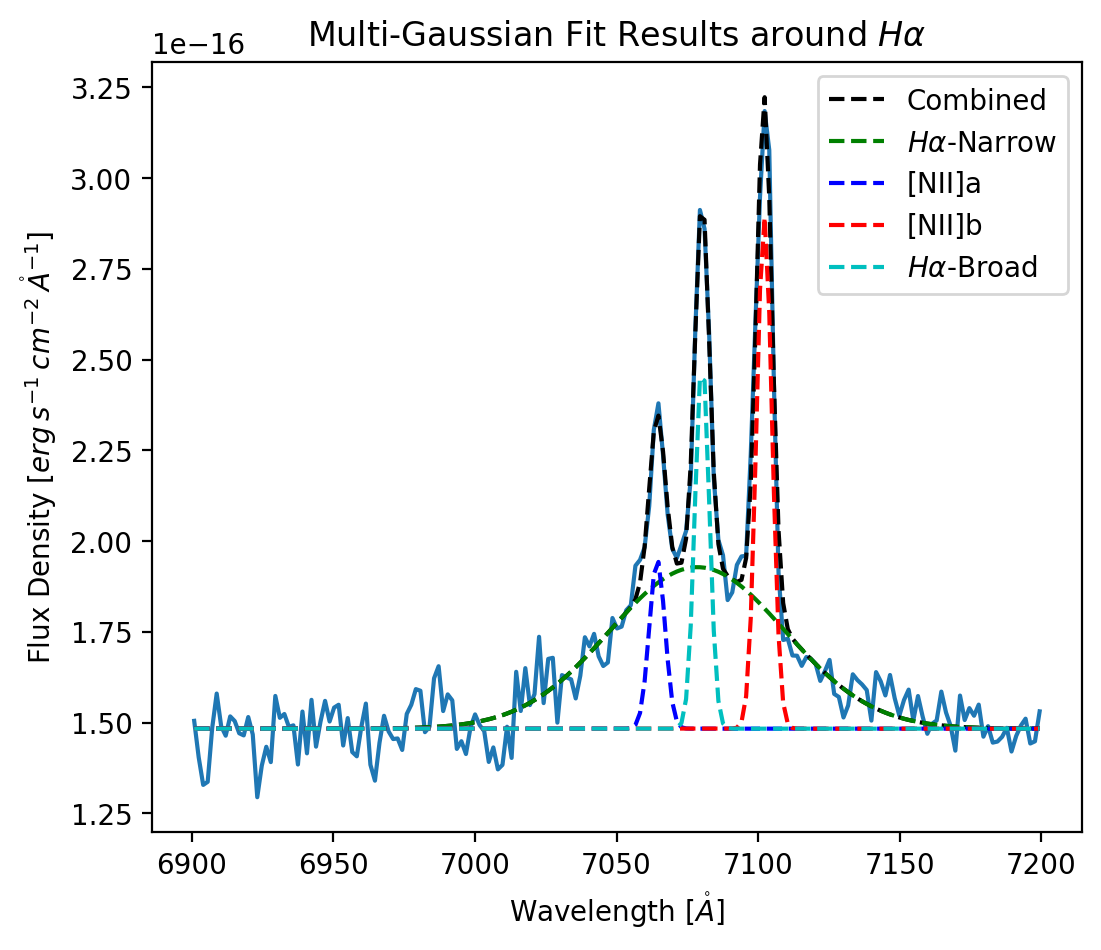

In [160]:
fig = plt.figure(figsize=(6,5), dpi=200)
plt.plot(wvl_1[slice_1], flux_1[slice_1])
plt.plot(wvl_1[slice_1], multi_gaussian4(wvl_1.value[slice_1],p_agn1[0], p_agn1[1], p_agn1[2], p_agn1[3],
                                                      p_agn1[4], p_agn1[5], p_agn1[6], p_agn1[7], p_agn1[8],
                                                      p_agn1[9], p_agn1[10], p_agn1[11], p_agn1[12]), 'k--', label='Combined')
plt.plot(wvl_1[slice_1], gaussian_profile(wvl_1.value[slice_1],p_agn1[4],p_agn1[0]+peak_guess0, p_agn1[8]) + p_agn1[12], 'g--', label=r'$H\alpha$-Narrow')
plt.plot(wvl_1[slice_1], gaussian_profile(wvl_1.value[slice_1],p_agn1[5],p_agn1[1]+peak_guess1, p_agn1[9]) + p_agn1[12], 'b--', label=r'[NII]a')
plt.plot(wvl_1[slice_1], gaussian_profile(wvl_1.value[slice_1],p_agn1[6],p_agn1[2]+peak_guess2, p_agn1[10]) + p_agn1[12], 'r--', label=r'[NII]b')
plt.plot(wvl_1[slice_1], gaussian_profile(wvl_1.value[slice_1],p_agn1[7],p_agn1[3]+peak_guess3, p_agn1[11]) + p_agn1[12], 'c--',label=r'$H\alpha$-Broad')
plt.title(r'Multi-Gaussian Fit Results around $H\alpha$')
plt.xlabel(r'Wavelength [$\mathring{A}$]')
plt.ylabel(r'Flux Density [$erg\: s^{-1} \: cm^{-2} \: \mathring{A}^{-1}$]')
plt.legend()
plt.show()


#**Block 5.5:**
**What about H-Beta**

Since we know the redshift (from the fit), we should be able to locate H-Beta (rest-wavelength around 4861 angstrom).

*   Use the obtained redshift to zoom in on H-Beta
*   Perform a multi-gaussian fit on the emission features around H-Beta.
*   Obtain the broad component of H-Beta.
*   Get the "rest-frame" velocity dispersion of the broad H-Beta emission in km/s and the "luminosity density" around 5100 angstrom.
*   Calculate the SMBH mass from the following equation (Park et al. 2015):

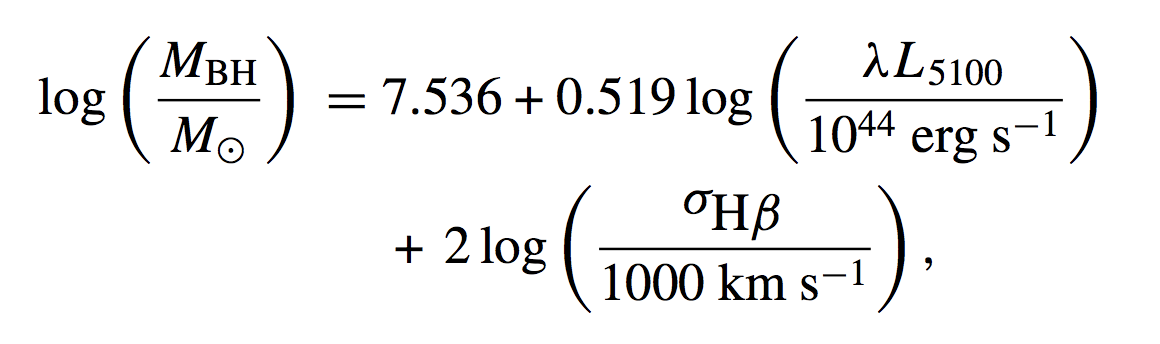


In [161]:
def log_M_BH_Park2015(L5100, sigma_hb_kms):
    log_M_BH_Park2015_est = 7.536 + 0.519*np.log10(5100.0*L5100/1.0e+44) + 2.0*np.log10(sigma_hb_kms/1000.0)
    return log_M_BH_Park2015_est



5243.411321247289
5400.321563197272


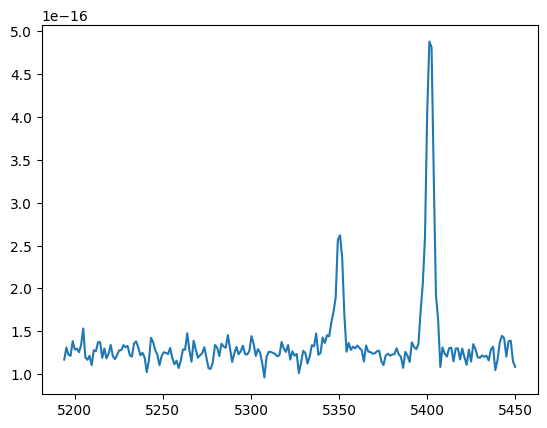

In [162]:
HBeta = 4862.721
OIIIa = 4960.295
OIIIb = 5008.239

slice_2 = np.where( (wvl_1.value < (OIIIb*(1.0+z_fitted) + 50.0)) & (wvl_1.value > (HBeta*(1.0+z_fitted) - 50.0)))
plt.plot(wvl_1[slice_2], flux_1[slice_2])
print(HBeta*(1.0+z_fitted))
print(OIIIb*(1.0+z_fitted))

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


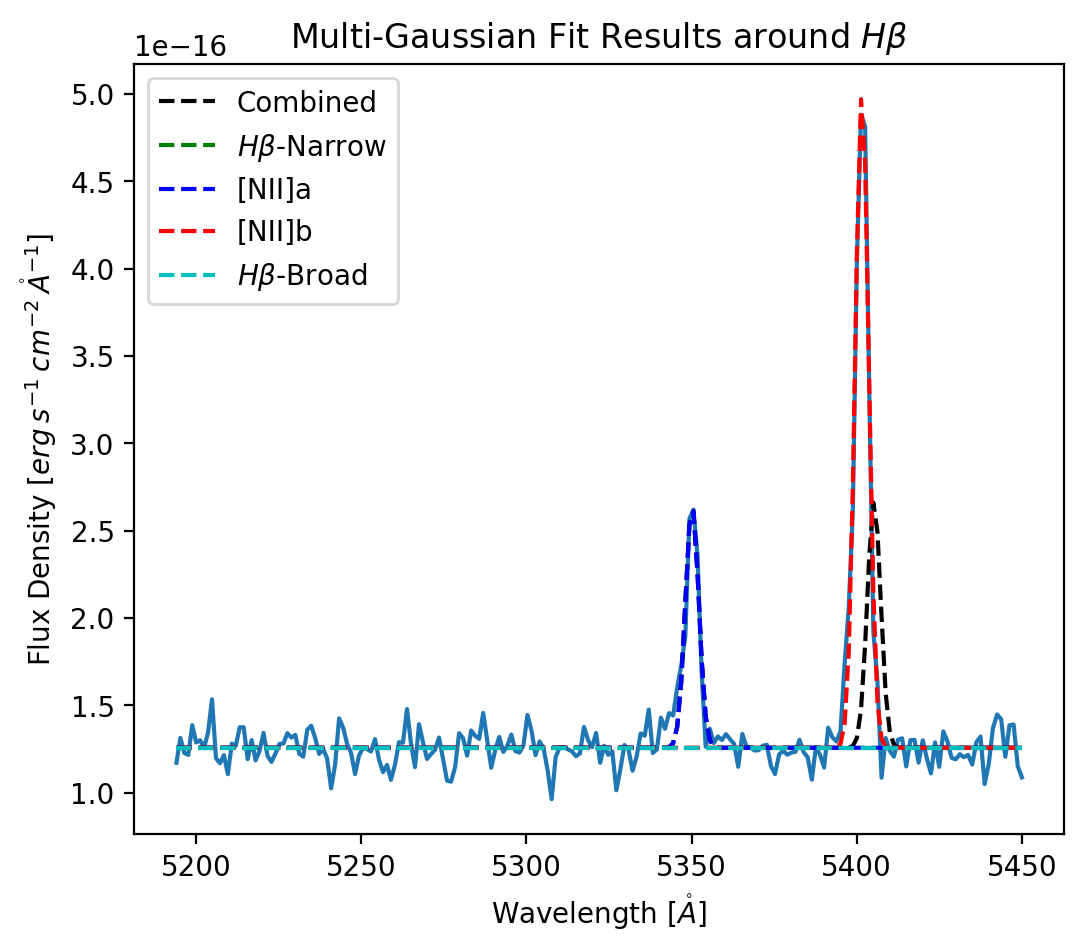

1.256304984716639e-16


In [163]:
peak_guess0 = HBeta
peak_guess1 = (1.0 + z_fitted)*OIIIa
peak_guess2 = (1.0 + z_fitted)*OIIIb
peak_guess3 = peak_guess0

p_agn2, pv_agn2 = curve_fit(multi_gaussian4, wvl_1.value[slice_2], flux_1.value[slice_2])

fig = plt.figure(figsize=(6,5), dpi=200)
plt.plot(wvl_1[slice_2], flux_1[slice_2])
plt.plot(wvl_1[slice_2], multi_gaussian4(wvl_1.value[slice_2],p_agn2[0], p_agn2[1], p_agn1[2], p_agn2[3],
                                                      p_agn2[4], p_agn2[5], p_agn1[6], p_agn2[7], p_agn2[8],
                                                      p_agn2[9], p_agn2[10], p_agn2[11], p_agn2[12]), 'k--', label='Combined')
plt.plot(wvl_1[slice_2], gaussian_profile(wvl_1.value[slice_2],p_agn2[4],p_agn2[0]+peak_guess0, p_agn2[8]) + p_agn2[12], 'g--', label=r'$H\beta$-Narrow')
plt.plot(wvl_1[slice_2], gaussian_profile(wvl_1.value[slice_2],p_agn2[5],p_agn2[1]+peak_guess1, p_agn2[9]) + p_agn2[12], 'b--', label=r'[NII]a')
plt.plot(wvl_1[slice_2], gaussian_profile(wvl_1.value[slice_2],p_agn2[6],p_agn2[2]+peak_guess2, p_agn2[10]) + p_agn2[12], 'r--', label=r'[NII]b')
plt.plot(wvl_1[slice_2], gaussian_profile(wvl_1.value[slice_2],p_agn2[7],p_agn2[3]+peak_guess3, p_agn2[11]) + p_agn2[12], 'c--',label=r'$H\beta$-Broad')
plt.title(r'Multi-Gaussian Fit Results around $H\beta$')
plt.xlabel(r'Wavelength [$\mathring{A}$]')
plt.ylabel(r'Flux Density [$erg\: s^{-1} \: cm^{-2} \: \mathring{A}^{-1}$]')
plt.legend()
plt.show()

print(p_agn2[12])



Now, it seemed like you broke Python...

But, did you?

Discuss, why it does or doesn't work.

What is wrong?

Could we calculate the mass of Super Massive Black Hole anyway???

In [164]:
f5100 = p_agn2[12]

cosmo = FlatLambdaCDM(H0 = 70.0 * u.km / u.s / u.Mpc, Om0 = 0.30, Tcmb0 = 2.725 * u.K)
xMpc = 1.0e+6 * u.parsec
cm_in_Mpc = xMpc.to(u.cm).value
d_L = (cosmo.luminosity_distance(z_fitted).value)*cm_in_Mpc
L5100 = (1.0 + z_fitted)*(4.0*np.pi*d_L**2.0)*f5100

print(L5100)
print(p_agn1[8]/Halpha*3.0e5)

2.0434214568597908e+39
1412.2140158559873


In [168]:
log_M_smbh = log_M_BH_Park2015(L5100, p_agn1[8]/Halpha*3.0e5)
print(log_M_smbh)

7.326105731991817
